# **Set-Up**

In [1]:
%pip install torchio --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.3/194.3 kB 9.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import torchio as tio 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import math
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm
from pathlib import Path
from tqdm import tqdm

%matplotlib inline

# **Pre-Processing**

In [3]:
labels_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)

labels_df = labels_df.groupby("patientId")["Target"].max().reset_index()

print(labels_df["Target"].value_counts())
print(labels_df.info(verbose=True, show_counts=True))

Target
0    20672
1     6012
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   Target     26684 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.1+ KB
None


In [4]:
labels_df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,000924cf-0f8d-42bd-9158-1af53881a557,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,1
3,000fe35a-2649-43d4-b027-e67796d412e0,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1


## Subjects

In [5]:
ROOT_PATH = Path("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/")
patient_dirs = list(ROOT_PATH.glob("*"))

patient_dirs[0] # debug

PosixPath('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/c3b05294-29be-46e4-8a51-96fd211e4ca5.dcm')

In [6]:
def get_patient_label(patient_path: Path, labels_df: pd.DataFrame) -> int:
    patientID = patient_path.stem
    label = labels_df.loc[labels_df["patientId"] == patientID, "Target"]
    label = label.iloc[0] if not label.empty else None
    return int(label)

In [7]:
subjects = []
heights = []
widths = []
labels = []

for subject_path in tqdm(patient_dirs):
    
    img_path = subject_path
    label = get_patient_label(subject_path, labels_df)

    ct = tio.ScalarImage(img_path)
    h, w, _ = ct.spatial_shape   

    subject = tio.Subject(
        CT = ct,
        Label = torch.tensor(label, dtype=torch.long),
        PatientID = subject_path.stem
    )

    subjects.append(subject)
    heights.append(h)
    widths.append(w)
    labels.append(label)

100%|██████████| 26684/26684 [19:37<00:00, 22.67it/s]


In [8]:
print(type(subjects[15]["CT"]), subjects[15]["CT"])
print(type(subjects[15]["Label"]), subjects[15]["Label"])
subjects[15]["CT"].spatial_shape

<class 'torchio.data.image.ScalarImage'> ScalarImage(shape: (1, 1024, 1024, 1); spacing: (0.17, 0.17, 1.00); orientation: LPS+; path: "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/7625412b-fbb0-46d7-9f7d-00b436cc467a.dcm")
<class 'torch.Tensor'> tensor(1)


(1024, 1024, 1)

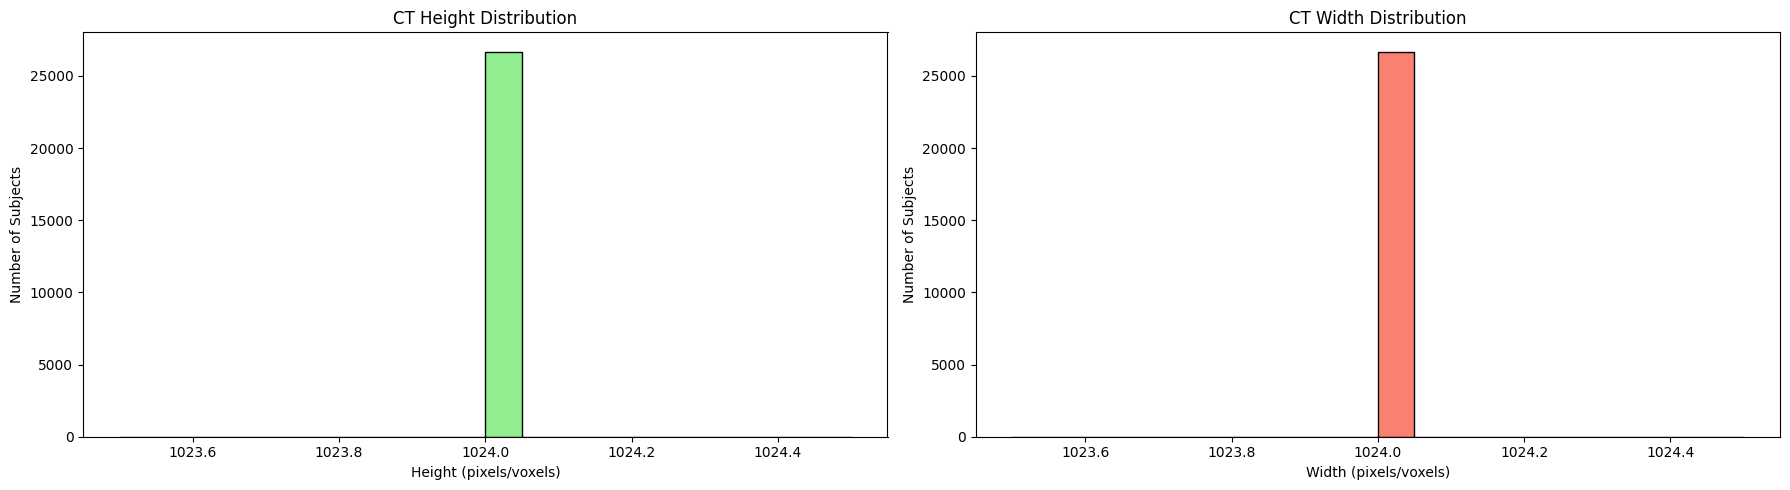

In [9]:
# Plot depth (dimensions)
plt.figure(figsize=(18,5))

# Plot height
plt.subplot(1,2,1)
plt.hist(heights, bins=20, color='lightgreen', edgecolor='black')
plt.title("CT Height Distribution")
plt.xlabel("Height (pixels/voxels)")
plt.ylabel("Number of Subjects")

# Plot width
plt.subplot(1,2,2)
plt.hist(widths, bins=20, color='salmon', edgecolor='black')
plt.title("CT Width Distribution")
plt.xlabel("Width (pixels/voxels)")
plt.ylabel("Number of Subjects")

plt.tight_layout()
plt.show()

In [10]:
img_size_og = subjects[15]["CT"].spatial_shape[0]

## **Transforms**

In [11]:
process = tio.Compose([
    tio.ToCanonical(),                        # step 1: fix orientation - RAS              
    tio.RescaleIntensity((0, 1)),                      # step 2: normalize intensity
    tio.Resize((356, 356, 1)),
    tio.CropOrPad((256, 256, 1)),          
])

augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))

train_transform = tio.Compose([process, augmentation])
val_transform = tio.Compose([process])

## **DataSet & DataLoader**

In [12]:
from sklearn.model_selection import train_test_split

# (90/10)
train_val_subjects, test_subjects = train_test_split(
    subjects,
    test_size=0.15,
    stratify=labels,
    random_state=42
)

# (80/20)
train_subjects, val_subjects = train_test_split(
    train_val_subjects,
    test_size=0.2,
    stratify=[s.Label.item() for s in train_val_subjects],
    random_state=42
)

# Verify class distributions
train_labels = [s.Label.item() for s in train_subjects]
val_labels   = [s.Label.item() for s in val_subjects]
test_labels  = [s.Label.item() for s in test_subjects]

print("Train counts:", np.bincount(train_labels))
print("Val counts:", np.bincount(val_labels))
print("Test counts:", np.bincount(test_labels))

Train counts: [14056  4088]
Val counts: [3515 1022]
Test counts: [3101  902]


In [13]:
train_dataset = tio.SubjectsDataset(train_subjects, transform = train_transform) 
val_dataset = tio.SubjectsDataset(val_subjects, transform = val_transform)  
test_dataset = tio.SubjectsDataset(test_subjects, transform = val_transform)  

In [14]:
from typing import Tuple, List

def collate_subjects(batch: List) -> Tuple[torch.Tensor, torch.Tensor]:
    images = torch.stack([s.CT.data for s in batch])
    labels = torch.tensor([s.Label.item() for s in batch])
    return images, labels

In [15]:
train_loader = DataLoader(train_dataset, batch_size=8, num_workers=4, collate_fn=collate_subjects, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=4, collate_fn=collate_subjects)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=4, collate_fn=collate_subjects)

In [16]:
x, y = next(iter(train_loader))
print(f"Images shape fresh off the loader: {x.shape}")
print(f"Labels shape fresh off the loader: {y.shape}")
print("Labels corresponding to 8 images in the batch: " + str(y))

Images shape fresh off the loader: torch.Size([8, 1, 256, 256, 1])
Labels shape fresh off the loader: torch.Size([8])
Labels corresponding to 8 images in the batch: tensor([0, 0, 1, 1, 0, 0, 1, 0])


# **Model**

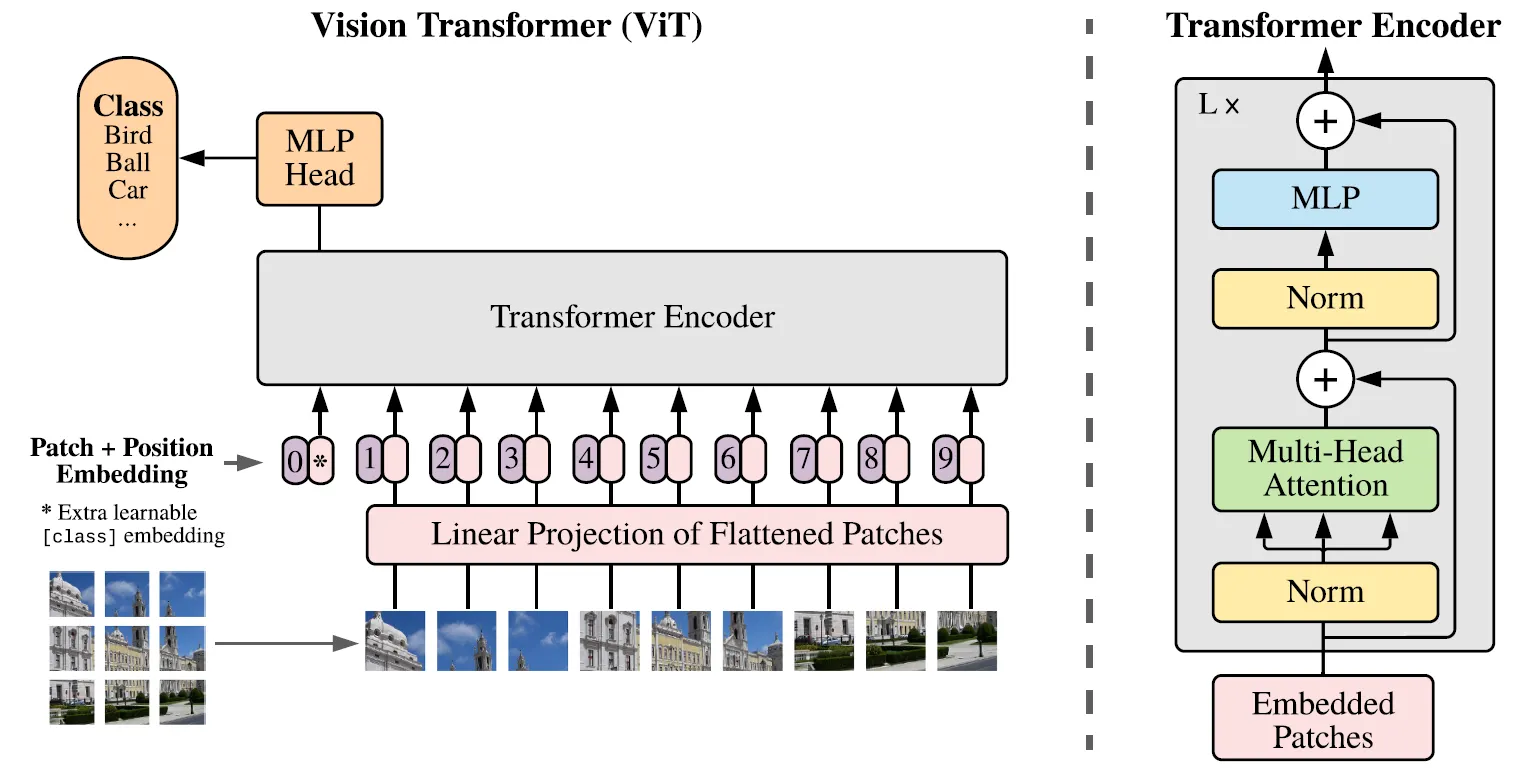
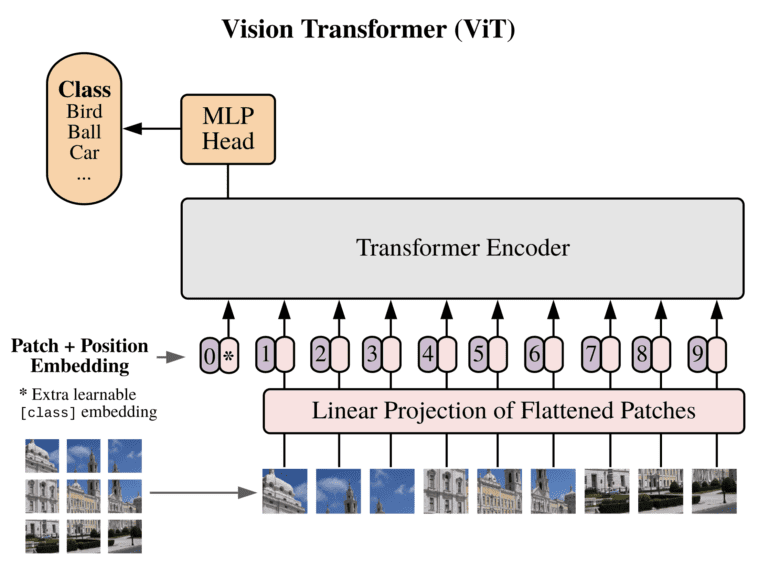

In [17]:
img_size = x.shape[2]
img_size

256

In [18]:
patch_size = 16

channels_in = x.shape[1]
print(f"Input Channels: {channels_in}")

hidden_size = 64 

num_tokens = (img_size//patch_size)**2 # num_patches
print(f"Number of patches/tokens: {num_tokens}")

num_heads = 4 # token_dim mod(num_heads) = 0
num_classes = 1
num_blocks = 8
learning_rate = 3e-4

Input Channels: 1
Number of patches/tokens: 256


## **Patch Embedding**

In [19]:
class PatchEmbedding(nn.Module):
    def __init__(self, channels_in, channels_out, patch_size): # c_out = hidden_size
        super().__init__()
        self.patch_embedder_2d = nn.Conv2d(
            channels_in,
            channels_out, # num of kernel-filters
            kernel_size = patch_size,
            stride = patch_size
        ) 

    def forward(self, x: torch.Tensor) -> torch.Tensor: # x: (b, c_in, h, w)
        x = self.patch_embedder_2d(x) # x: (b, c_out, h/p, w/p)
        x = x.flatten(2) # x: (b, c_out, h/p * w/p)
        x = x.transpose(1,2) # x: (b, hw/p.sq, c_out) # b -> tokens -> token_dim
        return x

## **Transformer Encoder**

In [20]:
class TransformerEncoder(nn.Module):
    def __init__(self, hidden_size, num_heads):  # hidden_size = token_dim
        super().__init__()
        # norm -> mha -(+)-> norm -> mlp -(+)-> return
        self.layernorm1 = nn.LayerNorm(hidden_size) 
        self.mha = nn.MultiheadAttention(hidden_size, num_heads, batch_first = True) # mha_dim = tokens_dim/num_heads (should be divisible)
        self.layernorm2 = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*2),
            nn.GELU(),
            nn.Linear(hidden_size*2, hidden_size)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        res1 = x
        x = self.layernorm1(x)
        x = self.mha(x, x, x)[0] # mha(query, key, value)[0] = context_vector at zeroth index
        x = x + res1
        
        res2 = x
        x = self.layernorm2(x)
        x = self.mlp(x)
        x = x + res2
        
        return x

## **MLP Head**

In [21]:
class MLPHead(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super().__init__()
        self.layernorm = nn.LayerNorm(hidden_size)
        self.mlp = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layernorm(x)
        x = self.mlp(x)
        return x

## **Vision Transformer**

In [22]:
class VisionTransformer(nn.Module):
    def __init__(self, channels_in, num_classes, hidden_size, patch_size, num_tokens ,num_heads, num_blocks):
        super().__init__()
        
        self.patch_embedding = PatchEmbedding(channels_in, hidden_size, patch_size)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_tokens + 1, hidden_size))

        self.transformer_blocks = nn.Sequential(*[TransformerEncoder(hidden_size, num_heads) for _ in range(num_blocks)])
        self.mlp_head = MLPHead(hidden_size, num_classes)    

    def forward(self, x):
        x = x.squeeze(-1)
        bs = x.shape[0] # if last batch contains images less than decided bs (data_len % bs != 0)

        x = self.patch_embedding(x)
        
        cls_token = self.cls_token.expand(bs, -1, -1)
    
        x = torch.cat((cls_token, x), dim=1) # if cat(x, cls) => last(-1th)-CLS vector i.e. x[:,-1]

        # cls: (B, 1, H)
        # x:   (B, num_tokens, H)
        # ----------------
        # out: (B, num_tokens+1, H)

        x = x + self.pos_embedding # (b, num_tokens+1, h) 

        x = self.transformer_blocks(x)
        x = x[:, 0] # (+1) zeroth-CLS vector across all batches

        x = self.mlp_head(x)
        
        return x

### **Two tensors can be added if:**

1. They have the same number of dimensions

2. For each dimension (from right to left):

    * Sizes are equal or

    * One of them is 1
  
**They add because:**

Dimension 1 broadcasts across batch, i.e. One tensor is automatically reused for every item in the batch, without copying it in memory.

# **Train**

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(channels_in, num_classes, hidden_size, patch_size, num_tokens ,num_heads, num_blocks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [24]:
# print(model)
x = torch.randn(8, 1, 256, 256, 1).to(device)
y = model(x)
print(y.shape)
print(f"How likely (logits) the model predicts each image in the batch to be pneumonic: \n{y}")
# y.argmax(dim=0)

torch.Size([8, 1])
How likely (logits) the model predicts each image in the batch to be pneumonic: 
tensor([[-0.1756],
        [-0.1963],
        [-0.2033],
        [-0.2194],
        [-0.2141],
        [-0.1886],
        [-0.1990],
        [-0.2179]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [25]:
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 300929 (Approximately 0 Million) Parameters!


In [26]:
from sklearn.metrics import accuracy_score, roc_curve, auc

In [27]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    print(f"\nEpoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # (B,1)

        optimizer.zero_grad()
        logits = model(images)                 # (B,1)
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # --- compute predictions ---
        probs = torch.sigmoid(logits)          # (B,1)
        preds = (probs > 0.5).long()           # binary 0/1
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu().long())

        if batch_idx % 500 == 0:
            batch_acc = accuracy_score(
                labels.cpu().numpy(), preds.cpu().numpy()
            ) * 100
            print(f"\nBatch {batch_idx+1:3d}: Loss = {loss.item():.4f} | Accuracy = {batch_acc:.2f}%")

    # --- epoch metrics ---
    all_preds_tensor = torch.cat(all_preds, dim=0)
    all_labels_tensor = torch.cat(all_labels, dim=0)

    epoch_acc = accuracy_score(all_labels_tensor.numpy(), all_preds_tensor.numpy()) * 100
    print(f"===> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f} | Accuracy = {epoch_acc:.2f}%")


Epoch 1

Batch   1: Loss = 0.6392 | Accuracy = 75.00%

Batch 501: Loss = 0.6389 | Accuracy = 62.50%

Batch 1001: Loss = 0.4199 | Accuracy = 75.00%

Batch 1501: Loss = 0.6160 | Accuracy = 75.00%

Batch 2001: Loss = 0.5648 | Accuracy = 75.00%
===> Epoch 1 Summary: Total Loss = 1095.1225 | Accuracy = 77.98%

Epoch 2

Batch   1: Loss = 0.2964 | Accuracy = 87.50%

Batch 501: Loss = 0.2954 | Accuracy = 100.00%

Batch 1001: Loss = 0.4184 | Accuracy = 75.00%

Batch 1501: Loss = 0.5096 | Accuracy = 62.50%

Batch 2001: Loss = 0.2667 | Accuracy = 87.50%
===> Epoch 2 Summary: Total Loss = 1023.7656 | Accuracy = 79.27%

Epoch 3

Batch   1: Loss = 0.7822 | Accuracy = 62.50%

Batch 501: Loss = 0.2656 | Accuracy = 87.50%

Batch 1001: Loss = 0.4495 | Accuracy = 75.00%

Batch 1501: Loss = 0.3339 | Accuracy = 87.50%

Batch 2001: Loss = 0.5920 | Accuracy = 75.00%
===> Epoch 3 Summary: Total Loss = 1009.4043 | Accuracy = 79.40%

Epoch 4

Batch   1: Loss = 0.5594 | Accuracy = 75.00%

Batch 501: Loss = 0.42

if num_classes > 1 with CrossEntropyLoss()

    epochs = 2
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_epoch = 0
        total_epoch = 0
        print(f"\nEpoch {epoch+1}")

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
    
            optimizer.zero_grad()
            logits = model(images)
            
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct = (preds == labels).sum().item()
            accuracy = 100.0 * correct / labels.size(0)
    
            correct_epoch += correct
            total_epoch += labels.size(0)
    
            if batch_idx % 100 == 0:
                print(f"\nBatch {batch_idx+1:3d}: Loss = {loss.item():.4f} | Accuracy = {accuracy:.2f}")
        
        epoch_acc = 100.0 * correct_epoch/total_epoch
        print(f"===> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f} | Accuracy = {epoch_acc:.2f}%")

# **Evaluate**

In [28]:
model.eval()
all_preds, all_labels, all_probs = [], [], []
val_loss = 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)   # (B,1)

        logits = model(images)                 # (B,1)
        loss = criterion(logits, labels)
        val_loss += loss.item()

        probs = torch.sigmoid(logits)          
        preds = (probs > 0.5).long()           

        all_probs.append(probs.cpu().view(-1))     # (B,)
        all_preds.append(preds.cpu().view(-1))     # (B,)
        all_labels.append(labels.cpu().view(-1))   # (B,)

# concatenate
all_probs = torch.cat(all_probs).numpy()
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# accuracy
val_acc = accuracy_score(all_labels, all_preds) * 100
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

Validation Loss: 233.8652 | Validation Accuracy: 81.00%


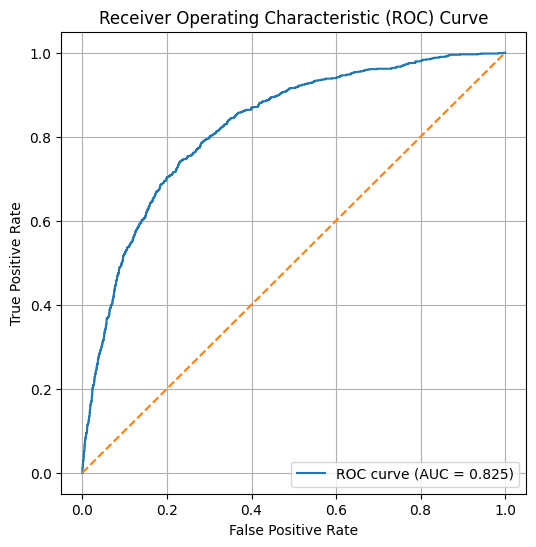

In [29]:
# ROC + AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()